<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd

Data preprocessing steps below to prepare for model training:


1.   only using the 0-20 measured or imputed SOC values
2.   minmax scalar normalizes all data between 0 and 1


The build_model function defines a neural network using Keras' Sequential model, so that the layers of the model are arranged in a sequence. Here's a breakdown of each component of the model:

1.  Input Shape and First Dense Layer:

*   Dense(256, activation='relu', input_dim=input_shape)

This is the first layer of the model, a fully connected (Dense) layer with 256 neurons. It uses the ReLU (Rectified Linear Unit) activation function. The input_dim parameter is set to input_shape, which specifies the shape of the input data the network expects. This layer takes the input data and begins the process of extracting features by applying weights, biases, and the ReLU activation.

2.   Batch Normalization:

This layer normalizes the activations of the previous layer at each batch, i.e., it applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. This helps in stabilizing the learning process and reducing the number of training epochs required to train deep networks.


3. Leaky ReLU Activation:  

*  LeakyReLU(alpha=0.2)

This is an activation layer that allows a small gradient when the unit is not active and the output is less than zero, which helps to keep the information flowing through the network. alpha is a coefficient for negative values, allowing a small negative slope (0.2 in this case).


4.  Dropout:

*   Dropout(0.3)

This layer randomly sets a fraction (30% here) of the input units to 0 at each update during training time, which helps to prevent overfitting.


5.  Additional Dense Layers:

Subsequent blocks of Dense, BatchNormalization, LeakyReLU, and Dropout layers follow the first block. These layers increase in size from 512 to 1024 neurons, continuing the pattern of extracting features and applying non-linearity and regularization techniques. Each dense layer serves to further refine the features extracted by the previous layers, with larger layers potentially capturing more complex patterns in the data.


6.   Output Layer:


*  Dense(1, activation='linear'):
This is the output layer of the model. It has 1 neuron, and it uses a linear activation function, which means the output is a direct weighted sum of the inputs. This type of output is typical for regression tasks or any task where you need a single continuous output value from the model.

Overall, this model architecture is typical for a deep learning task that requires capturing complex relationships in the data through successive layers of transformation and non-linear activation, combined with techniques to prevent overfitting (Batch Normalization and Dropout).


Why 256 neurons? The choice of 256 neurons in the first layer of a neural network is a bit arbitrary but can be grounded in several practical and theoretical considerations:

Power of Two: Often, the number of neurons in layers of neural networks are chosen to be powers of two (e.g., 64, 128, 256, 512). This choice is largely driven by computational efficiency—many hardware architectures and underlying mathematical libraries are optimized to handle data sizes that are powers of two more efficiently.
Model Capacity: The number of neurons in a layer determines its capacity to capture information. With 256 neurons, the layer can potentially learn more complex patterns in the data compared to a layer with fewer neurons. However, increasing the number of neurons also increases the risk of overfitting, especially if the amount of training data is not sufficiently large. Balancing this with techniques such as dropout and regularization is crucial.
Trade-off Between Performance and Complexity: Choosing the size of a layer involves balancing the computational cost and the model's performance. A larger layer (more neurons) can model more complex functions but requires more computation both in terms of memory and processing power. Conversely, a smaller layer may be less capable but more efficient. The number 256 is often seen as a good compromise in many applications, offering substantial modeling power without excessive computational demands.
Empirical Experience: Often, the choice of architecture parameters such as the number of neurons in a layer comes from empirical experience and experimentation. Researchers and practitioners might start with a configuration known to perform well on similar types of problems or datasets and adjust from there based on specific task performance and computational resources.
Scalability and Flexibility: Starting with 256 neurons in the first layer provides flexibility for scaling the model up or down. Depending on the outcomes of initial experiments, it's relatively straightforward to adjust the network size by adding more neurons or layers (scaling up) or reducing them (scaling down) to better fit the task without starting from scratch.
In practice, the specific choice of 256 neurons would ideally be validated through experimentation—testing the model's performance with different configurations and tuning based on validation results to find the best balance for the specific dataset and task at hand.

the use of mean squared error as the loss function = DL model for regression

Data Preparation:
**X = scaled_numeric_df.iloc[:, :-1]:** This line selects all rows and all columns except the last column of the dataframe scaled_numeric_df and assigns it to X. X contains the independent variables (features) used to predict the target variable.
**y = scaled_numeric_df.iloc[:, -1]:** This line selects all rows of the last column of scaled_numeric_df, which is assumed to be the dependent variable (target).
Train-Test Split:
**X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42):** This function splits the dataset into training and testing sets. test_size=0.2 indicates that 20% of the data will be set aside as the test set, and the remaining 80% will be used for training. The random_state parameter ensures that the split is reproducible.
Model Building and Compilation:
**model = build_model(X_train.shape[1]):** This calls the build_model function, which constructs a neural network model. The number of input dimensions (input_shape) is set to the number of features in X_train.
model.compile(...): This configures the model for training by setting the optimizer (Adam with a specific learning rate) and the loss function (mean_squared_error, suitable for regression tasks).
Model Training:
The model is trained three times with different learning rates and for different numbers of epochs. This approach, often called learning rate annealing or step decay, gradually decreases the learning rate:
First, the model is trained for 100 epochs with a learning rate of 0.001.
Then, it is recompiled with a lower learning rate of 0.0001 and trained for an additional 300 epochs.
Finally, it is recompiled again with an even lower learning rate of 0.00001 and trained for 600 more epochs.
validation_split=0.2 reserves 20% of the training data for validation to monitor and prevent overfitting.
batch_size=128 determines the number of samples per gradient update.
verbose=1 enables verbose output in the console, showing progress logs during training.
Model Evaluation:
**test_loss = model.evaluate(X_test, y_test):** After training, the model's performance is evaluated on the unseen test dataset. This function returns the loss (mean squared error in this case) calculated on the test set.

Generate Predictions:
**predictions = model.predict(X_test).flatten():** This line uses the trained model to make predictions on the test dataset (X_test). The .flatten() method is used to convert the output array into a 1D array if necessary, ensuring that predictions is a flat array.
Reverse Scaling of Predictions:
**dummy_array = np.full((len(predictions), 28), fill_value=0.5):** Creates a dummy array with the same number of rows as predictions and 28 columns, filling it with 0.5. The number 28 and the fill value 0.5 are placeholders and should be adjusted according to specific scaling details of the original data.
**dummy_array[:, -1] = predictions:** Places the predictions into the last column of dummy_array.
**inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]:** Uses the scaler to reverse the scaling transformation applied to the numeric data, extracting only the last column which contains the scaled predictions returned to their original scale.
Reverse Scaling of True Values:
**dummy_array[:, -1] = y_test:** Replaces the last column of dummy_array with the actual test target values (y_test).
**inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]:** Similarly, this line reverses the scaling of the true target values, allowing for direct comparison with the original target values in the dataset.
Compute R-Squared:
**r_squared = r2_score(inversed_truth, inversed_predictions):** Calculates the coefficient of determination
Return Statement:
**return model, test_loss, r_squared, inversed_predictions, scaler:** The function returns several objects:
model: The trained model object.
test_loss: The loss calculated on the test dataset, obtained from earlier model evaluation.
r_squared: The R-squared statistic for the predictions versus the actual test data.
inversed_predictions: The predictions of the model converted back to the original scale of the data.
scaler: The scaler object used for normalizing and reversing the normalization of the data.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

def preprocess_and_train_model(matched_data):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaler = MinMaxScaler()
    scaler.fit(numeric_cols)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    # Model Definition
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')  # Adjust output layer according to your needs
        ])
        return model

    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=300, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)

    # Predictions and Evaluation
    predictions = model.predict(X_test).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y_test
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    r_squared = r2_score(inversed_truth, inversed_predictions)

    return model, test_loss, r_squared, inversed_predictions, scaler

# Use the function with your DataFrame
# returns: model, test_loss, r_squared, predictions = preprocess_and_train_model(your_dataframe)


In [5]:
def predict_on_reserve(matched_data,model,scaler):
    # Data Preprocessing Steps
    # matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
    # matched_data = matched_data.reset_index(drop=True)
    matched_data['distance'] = 0
    unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    unique_rows = unique_rows[unique_rows['distance'] < 251]
    matched_data = unique_rows
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    numeric_cols = matched_data.iloc[:,keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]

    # Predictions and Evaluation
    predictions = model.predict(X).flatten()
    dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
    dummy_array[:, -1] = predictions
    inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
    dummy_array[:, -1] = y
    inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
    matched_data['inversed_predictions'] = inversed_predictions.flatten()
    matched_data['inversed_imp_c'] =inversed_truth.flatten()
    return matched_data

In [6]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [7]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [8]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [9]:
from shapely.geometry import Point

soils_csv = soils_csv[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'] )), axis=1)
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")

In [10]:


# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [11]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy()

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000).to_crs('ESRI:102261')

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', op='intersects')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [12]:
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


Create Reserve Dataset:
**reserve_data = matches_within_distance.groupby('unique_id').sample(n=1):** This line groups a DataFrame named matches_within_distance by the column unique_id and then samples one row from each group randomly. This results in a reserve_data DataFrame that contains a unique row for each unique_id, effectively creating a subset for later validation or testing.
Initialize Prediction List:
**prediction_list = []: **Initializes an empty list that will store the prediction results from multiple iterations of model training and prediction.
Iterative Model Training and Prediction:
The for loop (for i in range(10):) iterates ten times, each time performing the following steps:
**matched_data = matches_within_distance.groupby('unique_id').sample(n=1): **Similar to the creation of reserve_data, this samples one random row per unique_id group from the matches_within_distance DataFrame for use in training the model. This sampling is done in each iteration to potentially introduce variability in the training data across different iterations.
**matched_data = matched_data.reset_index(drop=True):** Resets the index of matched_data, dropping the old index to ensure the DataFrame is tidy and indices are sequential from zero, which is often necessary for data processing in machine learning tasks.
model, test_loss, r_squared, inversed_predictions, scaler = **preprocess_and_train_model(matched_data):** Calls the function preprocess_and_train_model with the newly sampled matched_data. This function is expected to preprocess the data, train a model, and return the trained model along with evaluation metrics and other relevant outputs (like the scaler used for normalizing data).
**predictions = predict_on_reserve(reserve_data, model, scaler):** Calls a function predict_on_reserve (which isn't defined in the provided script but is assumed to make predictions using the trained model and the scaler on the reserve_data). This function would apply the same preprocessing steps to the reserve_data as were applied to the training data, predict using the trained model, and return the predictions.
prediction_list.append(predictions): Appends the predictions from each iteration to the prediction_list. This list accumulates predictions from each of the ten training and prediction cycles.

In [13]:
# Use the function with your DataFrame
reserve_data = matches_within_distance.groupby('unique_id').sample(n=1)


prediction_list = []

for i in range(10):
  matched_data = matches_within_distance.groupby('unique_id').sample(n=1)
  matched_data = matched_data.reset_index(drop=True)
  model, test_loss, r_squared, inversed_predictions, scaler = preprocess_and_train_model(matched_data)

  predictions = predict_on_reserve(reserve_data,model,scaler)
  prediction_list.append(predictions)


<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 3s 98ms/step - loss: 3.1916 - val_loss: 0.1226
Epoch 2/100
5/5 [==============================] - 0s 27ms/step - loss: 2.7752 - val_loss: 0.0521
Epoch 3/100
5/5 [==============================] - 0s 26ms/step - loss: 2.3200 - val_loss: 0.0510
Epoch 4/100
5/5 [==============================] - 0s 26ms/step - loss: 1.9314 - val_loss: 0.0448
Epoch 5/100
5/5 [==============================] - 0s 24ms/step - loss: 1.7137 - val_loss: 0.0332
Epoch 6/100
5/5 [==============================] - 0s 24ms/step - loss: 2.1073 - val_loss: 0.0478
Epoch 7/100
5/5 [==============================] - 0s 24ms/step - loss: 1.7293 - val_loss: 0.0478
Epoch 8/100
5/5 [==============================] - 0s 25ms/step - loss: 1.4282 - val_loss: 0.0449
Epoch 9/100
5/5 [==============================] - 0s 24ms/step - loss: 1.2184 - val_loss: 0.0479
Epoch 10/100
5/5 [==============================] - 0s 25ms/step - loss: 1.2854 - val_loss: 0.0491
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


27/27 [==============================] - 0s 4ms/step


<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 85ms/step - loss: 2.7904 - val_loss: 0.0437
Epoch 2/100
5/5 [==============================] - 0s 25ms/step - loss: 2.4340 - val_loss: 0.0182
Epoch 3/100
5/5 [==============================] - 0s 26ms/step - loss: 2.5518 - val_loss: 0.0400
Epoch 4/100
5/5 [==============================] - 0s 26ms/step - loss: 2.1263 - val_loss: 0.0330
Epoch 5/100
5/5 [==============================] - 0s 24ms/step - loss: 1.7372 - val_loss: 0.0252
Epoch 6/100
5/5 [==============================] - 0s 26ms/step - loss: 1.5974 - val_loss: 0.0256
Epoch 7/100
5/5 [==============================] - 0s 28ms/step - loss: 1.3869 - val_loss: 0.0316
Epoch 8/100
5/5 [==============================] - 0s 30ms/step - loss: 1.3281 - val_loss: 0.0315
Epoch 9/100
5/5 [==============================] - 0s 25ms/step - loss: 1.2743 - val_loss: 0.0329
Epoch 10/100
5/5 [==============================] - 0s 28ms/step - loss: 1.2688 - val_loss: 0.0343
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


27/27 [==============================] - 0s 4ms/step


<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 80ms/step - loss: 2.4994 - val_loss: 0.0381
Epoch 2/100
5/5 [==============================] - 0s 24ms/step - loss: 1.8745 - val_loss: 0.0205
Epoch 3/100
5/5 [==============================] - 0s 24ms/step - loss: 1.9964 - val_loss: 0.0346
Epoch 4/100
5/5 [==============================] - 0s 24ms/step - loss: 2.0730 - val_loss: 0.0382
Epoch 5/100
5/5 [==============================] - 0s 25ms/step - loss: 1.7869 - val_loss: 0.0344
Epoch 6/100
5/5 [==============================] - 0s 24ms/step - loss: 1.5818 - val_loss: 0.0349
Epoch 7/100
5/5 [==============================] - 0s 24ms/step - loss: 1.9735 - val_loss: 0.0302
Epoch 8/100
5/5 [==============================] - 0s 25ms/step - loss: 2.0904 - val_loss: 0.0323
Epoch 9/100
5/5 [==============================] - 0s 23ms/step - loss: 1.8264 - val_loss: 0.0385
Epoch 10/100
5/5 [==============================] - 0s 24ms/step - loss: 1.3853 - val_loss: 0.0364
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


27/27 [==============================] - 0s 4ms/step


<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 3s 92ms/step - loss: 2.5728 - val_loss: 0.0189
Epoch 2/100
5/5 [==============================] - 0s 25ms/step - loss: 1.9854 - val_loss: 0.0499
Epoch 3/100
5/5 [==============================] - 0s 26ms/step - loss: 2.0908 - val_loss: 0.0412
Epoch 4/100
5/5 [==============================] - 0s 25ms/step - loss: 2.1040 - val_loss: 0.0233
Epoch 5/100
5/5 [==============================] - 0s 26ms/step - loss: 1.7776 - val_loss: 0.0246
Epoch 6/100
5/5 [==============================] - 0s 24ms/step - loss: 2.2635 - val_loss: 0.0313
Epoch 7/100
5/5 [==============================] - 0s 26ms/step - loss: 2.7603 - val_loss: 0.0252
Epoch 8/100
5/5 [==============================] - 0s 25ms/step - loss: 1.8483 - val_loss: 0.0260
Epoch 9/100
5/5 [==============================] - 0s 24ms/step - loss: 1.3511 - val_loss: 0.0309
Epoch 10/100
5/5 [==============================] - 0s 24ms/step - loss: 1.3458 - val_loss: 0.0308
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


27/27 [==============================] - 0s 5ms/step


<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 3s 83ms/step - loss: 2.1323 - val_loss: 0.0799
Epoch 2/100
5/5 [==============================] - 0s 25ms/step - loss: 2.3013 - val_loss: 0.0606
Epoch 3/100
5/5 [==============================] - 0s 27ms/step - loss: 2.4925 - val_loss: 0.0525
Epoch 4/100
5/5 [==============================] - 0s 26ms/step - loss: 2.0789 - val_loss: 0.0464
Epoch 5/100
5/5 [==============================] - 0s 25ms/step - loss: 2.5408 - val_loss: 0.0524
Epoch 6/100
5/5 [==============================] - 0s 25ms/step - loss: 2.0568 - val_loss: 0.0441
Epoch 7/100
5/5 [==============================] - 0s 25ms/step - loss: 1.9531 - val_loss: 0.0461
Epoch 8/100
5/5 [==============================] - 0s 25ms/step - loss: 1.4995 - val_loss: 0.0473
Epoch 9/100
5/5 [==============================] - 0s 26ms/step - loss: 1.1341 - val_loss: 0.0437
Epoch 10/100
5/5 [==============================] - 0s 25ms/step - loss: 1.2320 - val_loss: 0.0449
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


27/27 [==============================] - 0s 4ms/step


<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 82ms/step - loss: 2.3730 - val_loss: 0.0296
Epoch 2/100
5/5 [==============================] - 0s 25ms/step - loss: 2.4448 - val_loss: 0.0308
Epoch 3/100
5/5 [==============================] - 0s 25ms/step - loss: 2.1436 - val_loss: 0.0253
Epoch 4/100
5/5 [==============================] - 0s 25ms/step - loss: 2.6128 - val_loss: 0.0291
Epoch 5/100
5/5 [==============================] - 0s 25ms/step - loss: 2.0254 - val_loss: 0.0301
Epoch 6/100
5/5 [==============================] - 0s 25ms/step - loss: 2.1870 - val_loss: 0.0284
Epoch 7/100
5/5 [==============================] - 0s 25ms/step - loss: 1.7420 - val_loss: 0.0266
Epoch 8/100
5/5 [==============================] - 0s 25ms/step - loss: 1.2673 - val_loss: 0.0292
Epoch 9/100
5/5 [==============================] - 0s 24ms/step - loss: 1.2151 - val_loss: 0.0297
Epoch 10/100
5/5 [==============================] - 0s 25ms/step - loss: 1.8197 - val_loss: 0.0325
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


27/27 [==============================] - 0s 4ms/step


<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 95ms/step - loss: 2.5509 - val_loss: 0.0198
Epoch 2/100
5/5 [==============================] - 0s 30ms/step - loss: 2.5392 - val_loss: 0.0202
Epoch 3/100
5/5 [==============================] - 0s 30ms/step - loss: 2.6972 - val_loss: 0.0202
Epoch 4/100
5/5 [==============================] - 0s 27ms/step - loss: 1.4346 - val_loss: 0.0206
Epoch 5/100
5/5 [==============================] - 0s 28ms/step - loss: 2.0846 - val_loss: 0.0268
Epoch 6/100
5/5 [==============================] - 0s 30ms/step - loss: 2.4235 - val_loss: 0.0267
Epoch 7/100
5/5 [==============================] - 0s 26ms/step - loss: 1.7101 - val_loss: 0.0279
Epoch 8/100
5/5 [==============================] - 0s 26ms/step - loss: 1.5858 - val_loss: 0.0316
Epoch 9/100
5/5 [==============================] - 0s 28ms/step - loss: 2.4258 - val_loss: 0.0280
Epoch 10/100
5/5 [==============================] - 0s 29ms/step - loss: 1.2771 - val_loss: 0.0276
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 84ms/step - loss: 2.8558 - val_loss: 0.0628
Epoch 2/100
5/5 [==============================] - 0s 26ms/step - loss: 2.5096 - val_loss: 0.0497
Epoch 3/100
5/5 [==============================] - 0s 26ms/step - loss: 1.9571 - val_loss: 0.0553
Epoch 4/100
5/5 [==============================] - 0s 26ms/step - loss: 2.6721 - val_loss: 0.0477
Epoch 5/100
5/5 [==============================] - 0s 26ms/step - loss: 1.6177 - val_loss: 0.0514
Epoch 6/100
5/5 [==============================] - 0s 25ms/step - loss: 1.9526 - val_loss: 0.0412
Epoch 7/100
5/5 [==============================] - 0s 26ms/step - loss: 1.4047 - val_loss: 0.0430
Epoch 8/100
5/5 [==============================] - 0s 25ms/step - loss: 1.2537 - val_loss: 0.0442
Epoch 9/100
5/5 [==============================] - 0s 24ms/step - loss: 1.5188 - val_loss: 0.0454
Epoch 10/100
5/5 [==============================] - 0s 24ms/step - loss: 1.5305 - val_loss: 0.0433
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


27/27 [==============================] - 0s 4ms/step


<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 84ms/step - loss: 2.3362 - val_loss: 0.0390
Epoch 2/100
5/5 [==============================] - 0s 25ms/step - loss: 2.6207 - val_loss: 0.0400
Epoch 3/100
5/5 [==============================] - 0s 26ms/step - loss: 2.0576 - val_loss: 0.0383
Epoch 4/100
5/5 [==============================] - 0s 24ms/step - loss: 1.9015 - val_loss: 0.0400
Epoch 5/100
5/5 [==============================] - 0s 25ms/step - loss: 1.4933 - val_loss: 0.0406
Epoch 6/100
5/5 [==============================] - 0s 28ms/step - loss: 1.4943 - val_loss: 0.0362
Epoch 7/100
5/5 [==============================] - 0s 24ms/step - loss: 1.5373 - val_loss: 0.0381
Epoch 8/100
5/5 [==============================] - 0s 25ms/step - loss: 1.4516 - val_loss: 0.0374
Epoch 9/100
5/5 [==============================] - 0s 25ms/step - loss: 1.4417 - val_loss: 0.0359
Epoch 10/100
5/5 [==============================] - 0s 24ms/step - loss: 1.1302 - val_loss: 0.0404
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)
<ipython-input-4-757f94b23529>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


Epoch 1/100
5/5 [==============================] - 2s 78ms/step - loss: 2.3110 - val_loss: 0.1525
Epoch 2/100
5/5 [==============================] - 0s 26ms/step - loss: 2.7118 - val_loss: 0.0452
Epoch 3/100
5/5 [==============================] - 0s 26ms/step - loss: 1.9795 - val_loss: 0.0576
Epoch 4/100
5/5 [==============================] - 0s 26ms/step - loss: 2.4392 - val_loss: 0.0574
Epoch 5/100
5/5 [==============================] - 0s 26ms/step - loss: 1.6440 - val_loss: 0.0422
Epoch 6/100
5/5 [==============================] - 0s 25ms/step - loss: 1.7164 - val_loss: 0.0357
Epoch 7/100
5/5 [==============================] - 0s 24ms/step - loss: 1.5805 - val_loss: 0.0358
Epoch 8/100
5/5 [==============================] - 0s 26ms/step - loss: 1.5795 - val_loss: 0.0374
Epoch 9/100
5/5 [==============================] - 0s 24ms/step - loss: 1.3865 - val_loss: 0.0384
Epoch 10/100
5/5 [==============================] - 0s 26ms/step - loss: 1.2653 - val_loss: 0.0370
Epoch 11/100
5/5 [=

<ipython-input-5-8459f0b8cc1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [14]:
combined_array = np.array([predictions['inversed_predictions'].values for predictions in prediction_list])

In [15]:
combined_array[combined_array < 0 ] = 0

Flattening the Array:
**combined_array.flatten():** This method converts combined_array from a multi-dimensional array (e.g., 2D, 3D, etc.) into a 1D array. All elements of the original array are retained, but the structure is simplified into a single, flat sequence. Flattening is useful when you want to perform operations that do not need to preserve the array's multi-dimensional structure.
Finding Minimum and Maximum Values:
**arr_min = np.min(combined_array.flatten()):** After flattening the array, this function computes the minimum value across all the elements now present in the 1D version of combined_array. The result is stored in the variable arr_min.
**arr_max = np.max(combined_array.flatten()):** Similarly, this function computes the maximum value across all the elements in the flattened array. The result is stored in arr_max.
The purpose of these operations is typically to get a sense of the range of values contained within an array, which can be useful for tasks such as normalization, visualization, or setting scales in analytical models. The use of flatten() ensures that the minimum and maximum are calculated across the entire dataset, irrespective of its original shape.

In [16]:
arr_min = np.min(combined_array.flatten())
arr_max = np.max(combined_array.flatten())

two major operations on a NumPy 2D array called combined_array (2D since it is indexed by two dimensions: rows and columns). Here's the breakdown of each part of the code:

Creating dist_array:
This line creates a list of arrays where each array is a sorted version of the values from a specific column of combined_array.
for j in range(combined_array.shape[1]): This loop iterates over each column of combined_array (since combined_array.shape[1] refers to the number of columns in the array).
np.array([i[j] for i in combined_array]): For each column index j, a list comprehension is used to extract all elements from that column across all rows (i[j] for i in combined_array), and then this list is converted into a NumPy array.
np.sort(...): This function sorts the values in the newly created array from the smallest to the largest value.
The result is a list where each element is a sorted array of values from each column of combined_array.
Creating norm_dist_array:
This line performs a similar operation as for dist_array but includes normalization of the data before sorting.
The normalization is performed using the minimum (arr_min) and maximum (arr_max) values presumably found from the entire combined_array (as seen in your previous code snippet). Each value in the column is normalized by subtracting arr_min and dividing by the range (arr_max - arr_min).
The formula for normalization: ((np.array([i[j] for i in combined_array]) - arr_min) / (arr_max - arr_min)) scales the data such that all values are transformed to a scale of 0 to 1.
np.sort(...): After normalization, the values in each array are sorted.
The final result is a list of sorted, normalized arrays for each column.

In [17]:
dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

In [18]:
# norm_dist_array

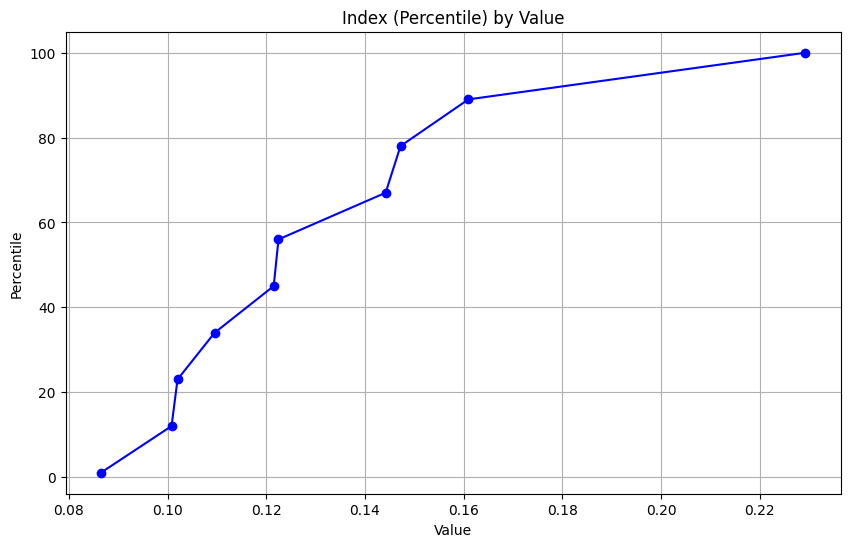

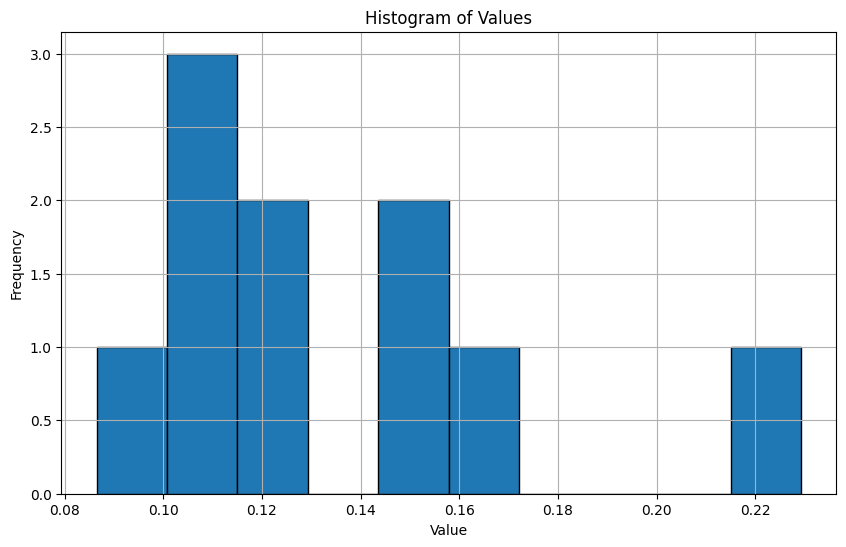

In [19]:
import numpy as np
import matplotlib.pyplot as plt

array = norm_dist_array[0]
# Generating y values as indices (percentiles in this context)
y_values = np.linspace(1, 100, len(array))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(array, y_values, marker='o', linestyle='-', color='b')
plt.title('Index (Percentile) by Value')
plt.xlabel('Value')
plt.ylabel('Percentile')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(array, bins=len(array), edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [20]:
# reserve_data

In [21]:
    # matched_data['distance'] = 0
    # unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
    # unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
    # unique_rows = unique_rows[unique_rows['distance'] < 251]
    # matched_data = unique_rows
    # matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
    # id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
    # keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
    # numeric_cols = matched_data.iloc[:,keep_cols]
    # numeric_cols.replace('', np.nan, inplace=True)
    # numeric_cols = numeric_cols.astype(float)
    # numeric_cols.fillna(0, inplace=True)
    # scaled_numeric_cols = scaler.transform(numeric_cols)
    # scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
    # numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

In [22]:
# predict_on_reserve(reserve_data,model,scaler)

In [23]:
matched_data = reserve_data

In [24]:
matched_data['distance'] = 0
unique_rows = matched_data[matched_data["depth_adj_bottom"] == '20']
unique_rows = unique_rows.drop_duplicates(subset=['latitude', 'longitude'])
unique_rows = unique_rows[unique_rows['distance'] < 251]
matched_data = unique_rows
matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]
id_fields = matched_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48, 55]
numeric_cols = matched_data.iloc[:,keep_cols]
numeric_cols.replace('', np.nan, inplace=True)
numeric_cols = numeric_cols.astype(float)
numeric_cols.fillna(0, inplace=True)
scaled_numeric_cols = scaler.transform(numeric_cols)
scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)
numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

<ipython-input-24-9b8c31e119ee>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [25]:
# keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48]

# numeric_cols = reserve_data[reserve_data["depth_adj_bottom"] == '20']


# numeric_cols = numeric_cols.iloc[:,keep_cols]

# scaler = MinMaxScaler()

# scaler.fit(numeric_cols)

# scaled_numeric_cols = scaler.transform(numeric_cols)

# scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df['dist_array'] = dist_array

scaled_numeric_df['norm_dist_array'] = norm_dist_array

# id_fields = pred_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

# numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


In [26]:
numeric_df.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'water',
       'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
       'built', 'bare', 'snow_and_ice', 'elevation', 'landform', 'SRTM_mTPI',
       'aet', 'pdsi', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn',
       'tmmx', 'vap', 'vpd', 'vs', 'agbd_m', 'imp_c_float'],
      dtype='object')

In [27]:
# Model Definition
def build_model(input_shape,output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')  # Adjust output layer according to your needs
    ])
    return model


In [28]:
scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()

In [29]:
scaled_numeric_df.dropna(inplace=True)

In [30]:
norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

In [31]:
scaled_numeric_df

,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice,elevation,...,srad,swe,tmmn,tmmx,vap,vpd,vs,agbd_m,imp_c_float,norm_dist_array
0,0.076076,0.783571,0.149382,0.226292,0.152680,0.141264,0.068871,0.067854,0.261028,0.015250,...,0.953306,0.0,0.924408,0.946761,0.947442,0.833201,0.510523,0.045160,0.079510,"[0.08647997825028171, 0.10080557597020605, 0.1..."
100,0.115113,0.185875,0.068776,0.215337,0.094502,0.125671,0.774552,0.073751,0.219645,0.076837,...,0.975217,0.0,0.904866,0.934330,0.924736,0.816007,0.514500,0.026085,0.080410,"[0.0, 0.02508900602397299, 0.04493573467210016..."
105,0.082975,0.974356,0.071786,0.179734,0.068668,0.083457,0.047745,0.061904,0.244318,0.100749,...,0.942586,0.0,0.876447,0.909543,0.898124,0.762932,0.542160,0.184082,0.178262,"[0.11362870097401827, 0.13869383770611804, 0.1..."
10,0.070384,0.945173,0.110528,0.156492,0.061417,0.097380,0.055518,0.062344,0.233075,0.066794,...,0.922799,0.0,0.884366,0.922948,0.922039,0.763581,0.495979,0.000000,0.123900,"[0.1263909439934863, 0.1385542065677635, 0.150..."
110,0.089377,0.921403,0.080722,0.193433,0.103035,0.104249,0.050258,0.066303,0.236237,0.073879,...,0.940739,0.0,0.881401,0.910243,0.898774,0.769978,0.544770,0.220331,0.048809,"[0.03778804025087988, 0.08030701266395913, 0.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6848,0.221200,0.513087,0.113476,0.253362,0.304016,0.119231,0.117652,0.153281,0.361658,0.001868,...,0.988551,0.0,0.945324,0.964298,0.965029,0.877881,0.549023,0.074080,0.026152,"[0.039474916764188454, 0.06034173568477682, 0...."
6849,0.134424,0.161670,0.509529,0.270847,0.262826,0.232430,0.129120,0.161867,0.386166,0.001673,...,0.988551,0.0,0.945324,0.964298,0.965029,0.877881,0.549023,0.036759,0.029655,"[0.025119064876109445, 0.0293788619426874, 0.0..."
6850,0.556739,0.386549,0.086588,0.254446,0.263514,0.122871,0.116759,0.156070,0.338921,0.001621,...,0.988551,0.0,0.945324,0.964298,0.965029,0.877881,0.549023,0.110970,0.028917,"[0.041709589603248096, 0.041928615287673186, 0..."
6851,0.217085,0.453058,0.283289,0.257519,0.202973,0.165620,0.080873,0.150969,0.352572,0.001781,...,0.988551,0.0,0.945324,0.964298,0.965029,0.877881,0.549023,0.050584,0.032236,"[0.03870918456078059, 0.04922705404561771, 0.0..."


In [32]:

X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

x = np.array(X)
y = np.array(norm_dist_array)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
# print(X_train.shape[1])
model = build_model(X_train.shape[1],output_shape=10)

In [34]:
y_train.shape

(679, 10)

In [35]:


# model = build_model((X_train.shape[1]))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = ['mae'])
# model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

test_loss = model.evaluate(X_test, y_test)

# Predictions and Evaluation
predictions = model.predict(X_test)
# dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
# dummy_array[:, -1] = predictions
# inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
# dummy_array[:, -1] = y_test
# inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]
# r_squared = r2_score(inversed_truth, inversed_predictions)

# return model, test_loss, r_squared, inversed_predictions, scaler

Epoch 1/600
5/5 [==============================] - 2s 94ms/step - loss: 2.0812 - mae: 1.0414 - val_loss: 0.0616 - val_mae: 0.1898
Epoch 2/600
5/5 [==============================] - 0s 28ms/step - loss: 1.9771 - mae: 1.0235 - val_loss: 0.0601 - val_mae: 0.1878
Epoch 3/600
5/5 [==============================] - 0s 28ms/step - loss: 1.8752 - mae: 0.9859 - val_loss: 0.0605 - val_mae: 0.1898
Epoch 4/600
5/5 [==============================] - 0s 27ms/step - loss: 1.6916 - mae: 0.9438 - val_loss: 0.0619 - val_mae: 0.1939
Epoch 5/600
5/5 [==============================] - 0s 26ms/step - loss: 1.7027 - mae: 0.9476 - val_loss: 0.0631 - val_mae: 0.1971
Epoch 6/600
5/5 [==============================] - 0s 27ms/step - loss: 1.6604 - mae: 0.9298 - val_loss: 0.0637 - val_mae: 0.1986
Epoch 7/600
5/5 [==============================] - 0s 26ms/step - loss: 1.5391 - mae: 0.9030 - val_loss: 0.0642 - val_mae: 0.2001
Epoch 8/600
5/5 [==============================] - 0s 26ms/step - loss: 1.5257 - mae: 0.88

In [36]:
i = 4
for i in range(5):
  print(predictions[i])
  print(y_test[i])

[0.25415197 0.33941633 0.34861535 0.35655797 0.39707336 0.4111236
 0.34608692 0.46772367 0.44895673 0.4302199 ]
[0.45162183 0.47420566 0.48208533 0.48867236 0.49203388 0.5091917
 0.51967821 0.5354121  0.5417475  0.57082891]
[0.22158611 0.23990808 0.18980893 0.20434052 0.2513557  0.22147027
 0.25666383 0.24401642 0.273184   0.26212695]
[0.25322473 0.25968512 0.26628597 0.26765175 0.26873026 0.27841289
 0.28017578 0.29801756 0.30725849 0.31700253]
[0.09852876 0.11058806 0.11440213 0.14365417 0.11865133 0.13419347
 0.12448056 0.13829485 0.14410262 0.17512065]
[0.17367952 0.18026968 0.18765013 0.20787083 0.21005756 0.21094983
 0.22814568 0.2357779  0.24231058 0.24376471]
[0.08439934 0.04742089 0.06942685 0.08568767 0.07626772 0.08923182
 0.13136491 0.0872359  0.16526794 0.17985964]
[0.0544786  0.05760596 0.05927779 0.05949813 0.06735793 0.07036816
 0.0828907  0.10016477 0.10957454 0.11572386]
[0.36700934 0.4036934  0.49960083 0.5072714  0.4451074  0.4651493
 0.5051682  0.5489002  0.4853605